In [1]:
import tkinter as tk
from tkinter import filedialog
import os
import numpy as np
import re
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, Conv1DTranspose, ZeroPadding1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import pandas as pd
import matplotlib.pyplot as plt
import gc
import pickle

In [2]:
# 符号付に変換する関数
def unsigned2signed(x):
    if x > 32767:
        return x - 65536
    return x

In [3]:
# 検証用データの読み込み
def load_val_data(val_folder_path):
    val_data = {}  # ファイルの拡張子と数字を除いたフルパスをキーとしたディクショナリ
    val_file_names = []  # ファイル名を格納するリスト

    for root, dirs, files in os.walk(val_folder_path):
        for file in files:
            match = re.match(r'(.+?)\.d(\d+)', file)  # 正規表現で.d○○の形式のファイル名を捉える
            if match:
                file_name, data_index = match.groups()
                data_index = int(data_index)
                full_path = os.path.join(root, file)  # フルパス
                full_path_key = full_path[:-4]  # 拡張子と数字を除いたフルパス
                if full_path_key not in val_data or data_index > val_data[full_path_key][8]:
                    with open(full_path, 'rb') as in_file:
                        buf = in_file.read()
                    # 8つのセンサーデータをグループ化
                    sensor_data = [buf[i:i+8*2] for i in range(408, len(buf), 8*2)]
                    sensor_values = []  # センサーデータを格納するリスト
                    for i in range(8):
                        sensor_values.append([unsigned2signed(int.from_bytes(sensor[i*2:i*2+2], 'little')) for sensor in sensor_data])
                    # 拡張子の番号を追加してデータをタプルに格納
                    sensor_values.append(int(data_index))
                    val_data[full_path_key] = sensor_values  # センサーデータと拡張子の番号をタプルに格納
                    val_file_names.append(file_name)  # ファイル名をリストに追加

    return val_data, val_file_names

# Tkinterを初期化
root = tk.Tk()
root.withdraw()  # メインウィンドウを非表示にする

# 検証データのフォルダを選択するためのダイアログを表示
val_folder_path = filedialog.askdirectory()

if val_folder_path:
    print("選択した検証データのフォルダ:", val_folder_path)
    # 検証データを読み込む
    val_data, val_data_filenames = load_val_data(val_folder_path)
    if val_data:
        print("検証データの読み込みが完了しました。")
    else:
        print("検証データが見つかりませんでした.")
else:
    print("検証データのフォルダが選択されませんでした.")

val_sensor_data_dict = {}  # 検証データのセンサーデータを格納するディクショナリ
for key, val_sensor_data in val_data.items():
    extension_number = val_sensor_data[-1]  # 拡張子の番号
    for i, val_sensor_value in enumerate(val_sensor_data[:-1]):  # 拡張子の番号を除くセンサーデータをループ
        val_sensor_key = f"{key}_{extension_number}_{i+1}"  # キーを生成
        if val_sensor_key not in val_sensor_data_dict:
            val_sensor_data_dict[val_sensor_key] = []  # キーが存在しない場合、空のリストを作成
        val_sensor_data_dict[val_sensor_key].append(val_sensor_value)  # キーに対応するリストに検証データのセンサーデータを追加

# データの形状を決定
num_val_samples = len(val_sensor_data_dict)
num_sensors = 8  # センサーの数

# 検証データの2次元のリストを初期化
val_data_matrix = [[None] * num_sensors for _ in range(num_val_samples)]

# 検証データのセンサーデータのみを保存する新しい変数を作成
val_sensor_data = []

# 検証データを2次元リストと新しい変数に配置
for i, (key, val_sensor_values) in enumerate(val_sensor_data_dict.items()):
    val_data_matrix[i] = [key] + val_sensor_values  # キーとセンサーデータのリストを1つのリストに格納
    val_sensor_data.append(val_sensor_values)  # 検証データのセンサーデータのリストを新しい変数に格納

# 3次元のリストを2次元のリストに変換する
reshaped_sensor_data = []
for sample in val_sensor_data:
    for val_sensor_values in sample:
        reshaped_sensor_data.append(val_sensor_values)

val_sensor_data = reshaped_sensor_data

# 検証データ
val_sensor_data_sca = []
for i in range(len(val_sensor_data)):
    mean = np.mean(val_sensor_data[i])
    std = np.std(val_sensor_data[i])

    #標準化処理を実行
    standardization_val_sensor_data = (val_sensor_data[i] - mean) / std
    val_sensor_data_sca.append(standardization_val_sensor_data)

# ゼロパディング
# ゼロパディングを行う（検証データ）
max_length = max(len(data) for data in val_sensor_data_sca)
padded_val_sensor_data = []
for data in val_sensor_data_sca:
    padding_length = max_length - len(data)
    padding_beginning = padding_length // 2
    padding_end = padding_length - padding_beginning
    padded_data = np.pad(data, (padding_beginning, padding_end), mode='constant', constant_values=0)
    padded_val_sensor_data.append(padded_data)

del padded_data, val_sensor_data_sca

# データをNumPyの配列に変換
padded_val_sensor_data = np.array(padded_val_sensor_data)

# チャンネル毎にデータを結合
ch = 8
concatenated_data_per_subject = []
for i in range(len(padded_val_sensor_data) // ch):  # 管の数だけループ
    subject_data = padded_val_sensor_data[i * ch:(i + 1) * ch]  # 同じ管のチャンネルのデータを取得
    concatenated_data = np.stack(subject_data, axis=-1)  # チャンネルのデータを1つの配列に連結
    concatenated_data_per_subject.append(concatenated_data)

# データをデータ長×8チャンネルの形状に整形する
reshaped_val_sensor_data = []
for data in concatenated_data_per_subject:
    reshaped_val_sensor_data.append(data.reshape(-1, ch))  # データ長×チャンネルの形状に変換し、リストに追加
reshaped_val_sensor_data = np.array(reshaped_val_sensor_data)  # リストをNumPy配列に変換

# 時間窓100サンプルで分割する
window_size = 100
new_data = []

for subject_data in reshaped_val_sensor_data:
    num_windows = (subject_data.shape[0] - window_size) // window_size + 1
    for start in range(0, subject_data.shape[0] - window_size + 1, window_size):
        window_data = subject_data[start:start + window_size]
        new_data.append(window_data)

# 最終的なデータセット
final_dataset = np.array(new_data)

print("最終的なデータセットの形状:", final_dataset.shape)

選択した検証データのフォルダ: C:/Users/r-fujita/Desktop/ET_Dataset/NG_test
検証データの読み込みが完了しました。
最終的なデータセットの形状: (345116, 100, 8)


In [4]:
############# 分割したデータを再合成するコード #############
# 元のセンサーデータの初期パディングと長さ
original_length = len(padded_val_sensor_data[0])
padding_length = max_length - original_length
padding_beginning = padding_length // 2

# final_dataset から再合成するデータを抽出
reconstructed_data = []

# 再合成に必要なウィンドウ数
num_windows = (original_length - window_size) // window_size + 1

# 再合成するためにfinal_datasetから該当するデータを抽出
for i in range(num_windows):
    start_index = i
    window_data = final_dataset[start_index]
    reconstructed_data.append(window_data)

# 最後の部分は残ったデータを追加
if (original_length - window_size) % window_size != 0:
    start_index = num_windows
    window_data = final_dataset[start_index]
    reconstructed_data.append(window_data)

# 連結して再合成
reconstructed_data = np.concatenate(reconstructed_data, axis=0)

# 元のパディングを取り除く
reconstructed_data = reconstructed_data[padding_beginning:padding_beginning + original_length]

print("再合成したデータの形状:", reconstructed_data.shape)

再合成したデータの形状: (36192, 8)


In [5]:
def stacked_what_where_autoencoder(input_shape):
    # Encoder
    inputs = Input(shape=input_shape)
    conv1 = Conv1D(32, 10, activation='selu', padding='same')(inputs)
    pool1 = MaxPooling1D(pool_size=2, padding='same')(conv1)  
    conv2 = Conv1D(64, 5, activation='selu', padding='same')(pool1)
    pool2 = MaxPooling1D(pool_size=2, padding='same')(conv2)  

    # Decoder
    conv3 = Conv1DTranspose(64, 5, strides=2, activation='selu', padding='same')(pool2)
    conv4 = Conv1DTranspose(32, 10, strides=2, activation='selu', padding='same')(conv3)
    decoded = Conv1DTranspose(input_shape[-1], 7, padding='same')(conv4)  # 出力形状を入力形状と一致させる

    # Autoencoder Model
    autoencoder = Model(inputs, decoded)
    return autoencoder

In [6]:
# 入力データの形状を取得
input_shape = final_dataset.shape[1:]

# Stacked What-Where Autoencoderを構築
autoencoder = stacked_what_where_autoencoder(input_shape)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# モデルのサマリを表示
autoencoder.summary()

# モデルの学習
history = autoencoder.fit(final_dataset, final_dataset, epochs=20, batch_size=8, shuffle=True, verbose=1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 8)]          0         
                                                                 
 conv1d (Conv1D)             (None, 100, 32)           2592      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 50, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 50, 64)            10304     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 25, 64)           0         
 1D)                                                             
                                                                 
 conv1d_transpose (Conv1DTra  (None, 50, 64)           20544 

In [7]:
# テストデータの読み込み（例としてreshaped_val_sensor_dataを使用）
test_data = reshaped_val_sensor_data

# 時間窓100でテストデータを分割する関数
def create_windows(data, window_size):
    windows = []
    start_indices = []
    for i in range(data.shape[0]):
        for start in range(0, data.shape[1] - window_size + 1, window_size):
            windows.append(data[i, start:start + window_size, :])
            start_indices.append((i, start))
    return np.array(windows), start_indices

# 時間窓100で分割
window_size = 100
test_windows, start_indices = create_windows(test_data, window_size)
print("テストウィンドウの形状:", test_windows.shape)
print("ウィンドウの開始インデックス:", start_indices[:5])


テストウィンドウの形状: (345116, 100, 8)
ウィンドウの開始インデックス: [(0, 0), (0, 100), (0, 200), (0, 300), (0, 400)]


In [10]:
# 再構成誤差の計算関数
def calculate_reconstruction_error(test_windows, model):
    reconstructed_windows = model.predict(test_windows)
    mse = np.mean(np.power(test_windows - reconstructed_windows, 2), axis=(1, 2))
    return mse

# オートエンコーダで再構成誤差を計算
reconstruction_errors = calculate_reconstruction_error(test_windows, autoencoder)
print("再構成誤差の形状:", reconstruction_errors.shape)

10785/10785 [==============================] - 19s 2ms/step
再構成誤差の形状: (345116,)


In [12]:
# 再構成誤差とウィンドウの開始インデックスを関連付ける
error_with_indices = list(zip(start_indices, reconstruction_errors))

# 異常検知の結果を表示
for (i, start), error in error_with_indices[:50]:  # 最初の50サンプルのみを表示
    print(f"データ番号 {i} の位置 {start} からのウィンドウの再構成誤差: {error}")

データ番号 0 の位置 0 からのウィンドウの再構成誤差: 0.00136526276443658
データ番号 0 の位置 100 からのウィンドウの再構成誤差: 0.00136526276443658
データ番号 0 の位置 200 からのウィンドウの再構成誤差: 0.00136526276443658
データ番号 0 の位置 300 からのウィンドウの再構成誤差: 0.00136526276443658
データ番号 0 の位置 400 からのウィンドウの再構成誤差: 0.00136526276443658
データ番号 0 の位置 500 からのウィンドウの再構成誤差: 0.00136526276443658
データ番号 0 の位置 600 からのウィンドウの再構成誤差: 0.00136526276443658
データ番号 0 の位置 700 からのウィンドウの再構成誤差: 0.00136526276443658
データ番号 0 の位置 800 からのウィンドウの再構成誤差: 0.00136526276443658
データ番号 0 の位置 900 からのウィンドウの再構成誤差: 0.00136526276443658
データ番号 0 の位置 1000 からのウィンドウの再構成誤差: 0.00136526276443658
データ番号 0 の位置 1100 からのウィンドウの再構成誤差: 0.00136526276443658
データ番号 0 の位置 1200 からのウィンドウの再構成誤差: 0.00136526276443658
データ番号 0 の位置 1300 からのウィンドウの再構成誤差: 0.00136526276443658
データ番号 0 の位置 1400 からのウィンドウの再構成誤差: 0.00136526276443658
データ番号 0 の位置 1500 からのウィンドウの再構成誤差: 0.00136526276443658
データ番号 0 の位置 1600 からのウィンドウの再構成誤差: 0.00136526276443658
データ番号 0 の位置 1700 からのウィンドウの再構成誤差: 0.00136526276443658
データ番号 0 の位置 1800 からのウィンドウの再構成誤差: 0.00136526276443658
データ番号

再合成したデータの形状: (36192, 8)


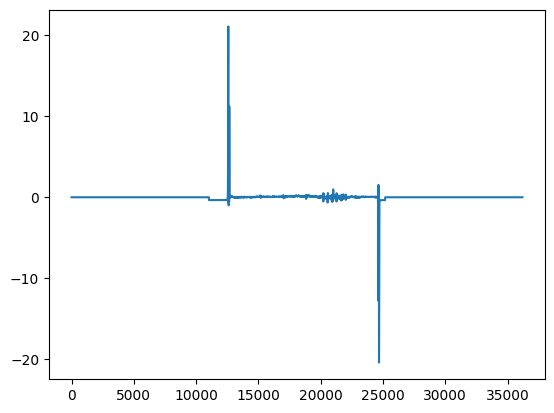

In [12]:
def stacked_what_where_autoencoder(input_shape):
    # Encoder
    inputs = Input(shape=input_shape)
    conv1 = Conv1D(32, 10, activation='selu', padding='same')(inputs)
    pool1 = MaxPooling1D(pool_size=2, padding='same')(conv1)  
    conv2 = Conv1D(64, 5, activation='selu', padding='same')(pool1)
    pool2 = MaxPooling1D(pool_size=2, padding='same')(conv2)  

    # Decoder
    conv3 = Conv1DTranspose(64, 5, strides=2, activation='selu', padding='same')(pool2)
    conv4 = Conv1DTranspose(32, 10, strides=2, activation='selu', padding='same')(conv3)
    decoded = Conv1DTranspose(input_shape[-1], 7, padding='same')(conv4)  # 出力形状を入力形状と一致させる

    # Autoencoder Model
    autoencoder = Model(inputs, decoded)
    return autoencoder

In [13]:
# 入力データの形状を取得
input_shape = reshaped_sensor_data.shape[1:]

# Stacked What-Where Autoencoderを構築
autoencoder = stacked_what_where_autoencoder(input_shape)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# モデルのサマリを表示
autoencoder.summary()

# モデルの学習
history = autoencoder.fit(reshaped_sensor_data, reshaped_sensor_data, epochs=100, batch_size=8, shuffle=True, verbose=1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14648, 8)]        0         
                                                                 
 conv1d (Conv1D)             (None, 14648, 32)         2592      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 7324, 32)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 7324, 64)          10304     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 3662, 64)         0         
 1D)                                                             
                                                                 
 conv1d_transpose (Conv1DTra  (None, 7324, 64)         20544 

In [15]:
# テストデータの再構築を行い再構成誤差を計算する
reconstructed_test_data = autoencoder.predict(reshaped_test_sensor_data)
mse_test = np.mean(np.square(reshaped_test_sensor_data - reconstructed_test_data), axis=(1, 2))

3/3 [==============================] - 1s 71ms/step


In [16]:
# 学習データの再構成を行い再構成誤差を計算する
# reconstructed_data = autoencoder.predict(reshaped_sensor_data)
# mse = np.mean(np.square(reshaped_sensor_data - reconstructed_data), axis=(1, 2))

In [17]:
# 検証データの再構築を行い再構成誤差を計算する
reconstructed_val_data = autoencoder.predict(reshaped_val_sensor_data)
mse_val = np.mean(np.square(reshaped_val_sensor_data - reconstructed_val_data), axis=(1, 2))

2/2 [==============================] - 0s 389ms/step
